# Background

There has been a revenue decline in the Portuguese Bank and they would like to know what actions to take. After investigation, they found that the root cause was that their customers are not investing enough for long term deposits. So the bank would like to identify existing customers that have a higher chance to subscribe for a long term deposit and focus marketing efforts on such customers.

# Problem Description

- Machine Learning is utilized in this scenario to analyze and predict customer behavior, specifically targeting those likely to subscribe to a term deposit. The decline in revenue due to a lack of long-term investments can be addressed by identifying patterns in customer data that correlate with the likelihood of subscribing to term deposits. Using ML algorithms can help in efficiently processing large volumes of customer data, uncovering insights that are not immediately apparent, and automating the prediction process to assist in making data-driven marketing and business decisions.
- `The task` is to predict whether a bank's customers will subscribe to a term deposit, which is a binary classification problem.
- `The data` consists of historical customer information from the bank, which includes demographic details, account information, and past interactions with the bank.
- `Performance metrics` could include accuracy, precision, recall, F1-score.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from category_encoders.cat_boost import CatBoostEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Data Overview

In [2]:
# Load the dataset
Data = pd.read_csv('banking_data.csv')

# First look at the data to understand its structure
Data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [3]:
# Let's check the datatypes of the columns in the dataset
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


- There are `32950` observations and `16` columns in the data.
- `11` columns are of the object datatype and `5` columns are numerical.

In [4]:
# Let's check for duplicate values in the data
Data.duplicated().sum()

8

- There are `8` duplicates in the data.

In [5]:
# Let's check for missing values in the data
round(Data.isnull().sum() / Data.isnull().count() * 100, 2)

age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
duration       0.0
campaign       0.0
pdays          0.0
previous       0.0
poutcome       0.0
y              0.0
dtype: float64

- It can be observed that there are no missing values in the data.

In [6]:
# Let's view the statistical summary of the numerical columns in the data
Data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32950.0,40.014112,10.403636,17.0,32.0,38.0,47.0,98.0
duration,32950.0,258.127466,258.975917,0.0,103.0,180.0,319.0,4918.0
campaign,32950.0,2.560607,2.752326,1.0,1.0,2.0,3.0,56.0
pdays,32950.0,962.052413,187.951096,0.0,999.0,999.0,999.0,999.0
previous,32950.0,0.174719,0.499025,0.0,0.0,0.0,0.0,7.0


#### Observations
- `Age:` The average age of the bank's clients in this dataset is around 40 years old, with the youngest being 17 and the oldest 98. Most clients are in their 30s to 40s, which is typical for a working and economically active population.
- `Duration:` The average duration of the last contact with the clients was about 258 seconds, but there's a big range, from just a few seconds (10 seconds) to over an hour (4918 seconds). This suggests there's a lot of variation in how long the bank's employees are talking to clients.
- `Campaign:` On average, a client was contacted about 2.5 times during the current campaign, with a maximum of 56 times. This could imply that while some clients need more persuasion, the bank doesn't usually go beyond a handful of contacts.
- `Pdays:` The '999' value indicates that many clients were not previously contacted, which aligns with the 'previous' column average being close to zero. This means the current campaign might be the first direct marketing interaction for most clients.
- `Previous:` The low average (about 0.17) suggests that there were very few contacts with clients before the current campaign. This could mean the bank has not been very aggressive in its past marketing efforts or is reaching out to new clients.

In [7]:
# Let's check the number of unique values in each column
Data.nunique()

age              75
job              12
marital           4
education         8
default           3
housing           3
loan              3
contact           2
month            10
day_of_week       5
duration       1467
campaign         40
pdays            27
previous          8
poutcome          3
y                 2
dtype: int64

- The `duration` has the most unique value following the `age` column with `75` unique values. It can be observed the `y` column, which is the target variable has `2` unique values as it suggests it's a binary classification problem.

In [8]:
for i in Data.describe(include=["object"]).columns:
    print("Unique values in", i, "are :")
    print(Data[i].value_counts())
    print("*" * 50)

Unique values in job are :
admin.           8314
blue-collar      7441
technician       5400
services         3196
management       2345
retired          1366
entrepreneur     1160
self-employed    1099
housemaid         855
unemployed        798
student           711
unknown           265
Name: job, dtype: int64
**************************************************
Unique values in marital are :
married     19953
single       9257
divorced     3675
unknown        65
Name: marital, dtype: int64
**************************************************
Unique values in education are :
university.degree      9736
high.school            7596
basic.9y               4826
professional.course    4192
basic.4y               3322
basic.6y               1865
unknown                1397
illiterate               16
Name: education, dtype: int64
**************************************************
Unique values in default are :
no         26007
unknown     6940
yes            3
Name: default, dtype: int64
****

#### Observations
- `Job:` The most common job among clients is 'blue-collar', followed by 'admin.' and 'technician'. There are a few clients with 'unknown' job types.
- `Marital Status:` Most clients are married, then single, with a small number marked as 'unknown'.
- `Education:` A large portion of clients have a 'university.degree', and quite a few have completed 'high.school'. There are very few 'illiterate' clients.
- `Credit in Default:` Most clients do not have credit in default, and a significant number have 'unknown' status in this regard.
- `Housing Loan:` More clients have a housing loan than those who do not.
- `Personal Loan:` The majority of clients do not have a personal loan.
- `Contact:` 'Cellular' seems to be the preferred way of contacting clients, more so than 'telephone'.
- `Month of Last Contact:` 'May' is the most common month for last contact with clients, followed by 'July', 'August', and 'June'. The winter months like 'December' see very little activity.
- `Day of the Week:` The distribution of the last contact days is quite even across the weekdays, with 'Thursday' being slightly higher.
- `Outcome of the Previous Marketing Campaign:` Most clients have not been contacted before ('nonexistent'), and there are more 'failures' than 'successes'.

# Data Pre-processing

- Dropping duplicates

In [9]:
Data.drop_duplicates(inplace=True)

- Renaming target column

In [10]:
Data.rename(columns={'y': 'term_deposit'}, inplace=True)

# Expolatory Data Analysis

## Univariate Analysis

In [11]:
# Function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

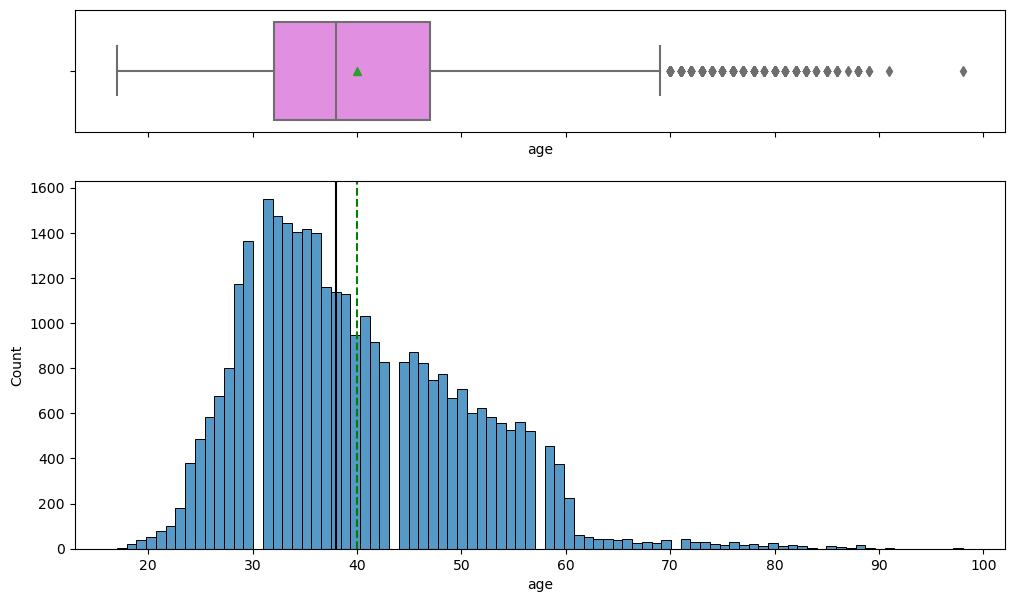

In [12]:
histogram_boxplot(Data, "age")

- It can be observed that most clients are in their `30s and 40s`, with fewer clients as the age increases. The boxplot suggests that the middle half of the client ages are tightly packed around the median, indicating a consistent age range among most clients.

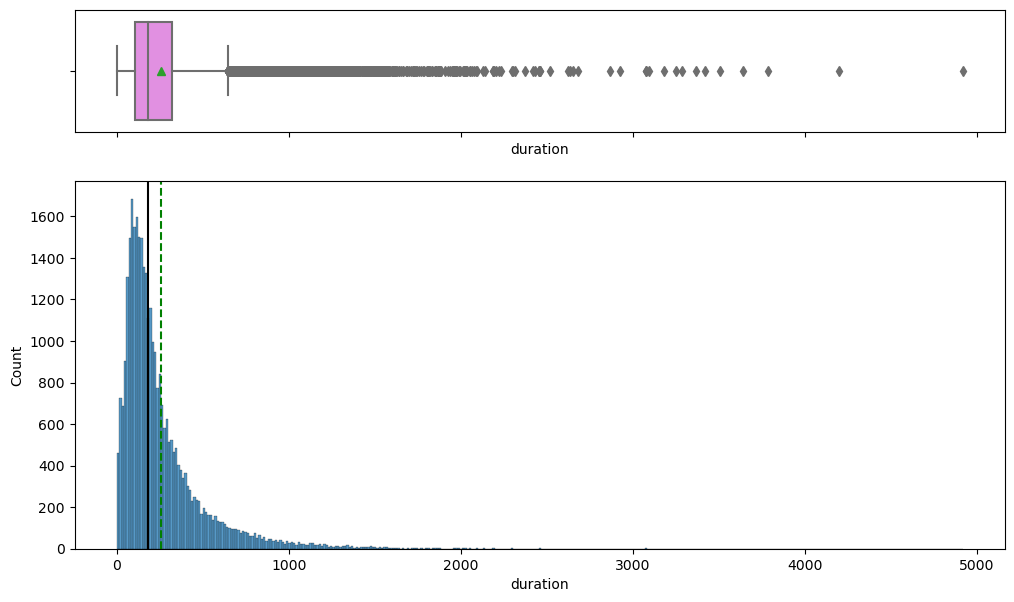

In [13]:
histogram_boxplot(Data, "duration")

- The graph depicts the length of phone calls with bank clients. Most calls were short, with a steep drop-off as duration increases. There are some very long calls, but these are rare, as shown by the few dots far to the right on the boxplot, which represent outliers.

In [14]:
# Function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

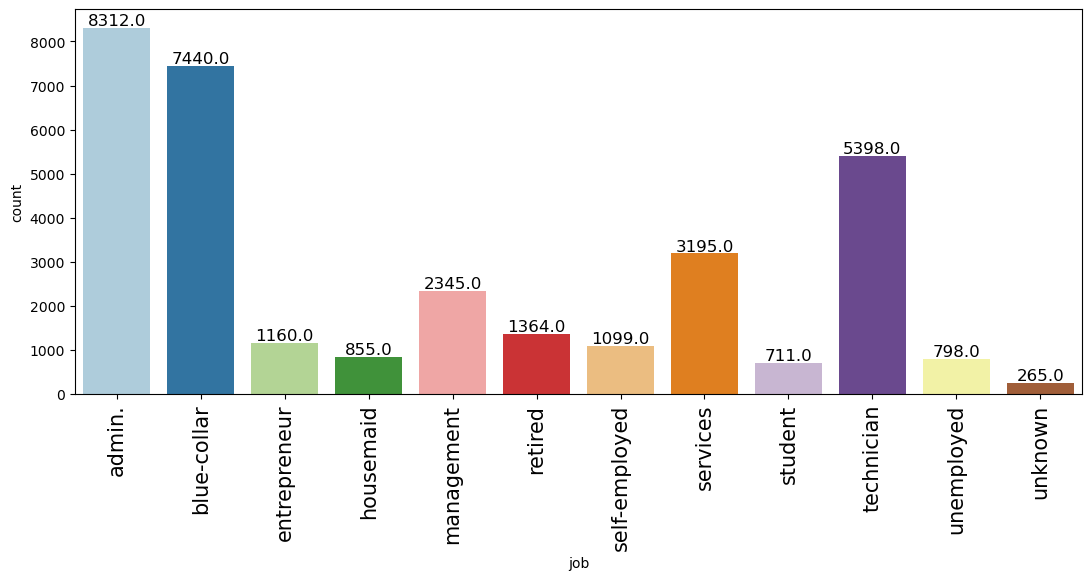

In [15]:
labeled_barplot(Data, "job")

- The bar chart shows the job categories of the bank's clients. 'Admin.' and 'blue-collar' are the most common jobs, with a lot of clients working in these roles. 'Student', 'unemployed', and 'unknown' categories have the fewest numbers, indicating they make up a smaller portion of the bank's clientele.

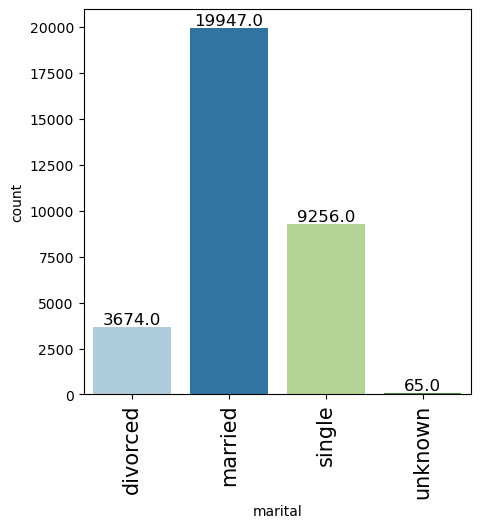

In [16]:
labeled_barplot(Data, "marital")

- The bar chart highlights the marital status of the bank's clients. The majority are married, followed by a significant number who are single. Divorced clients are fewer, and there's a very small count categorized as unknown.

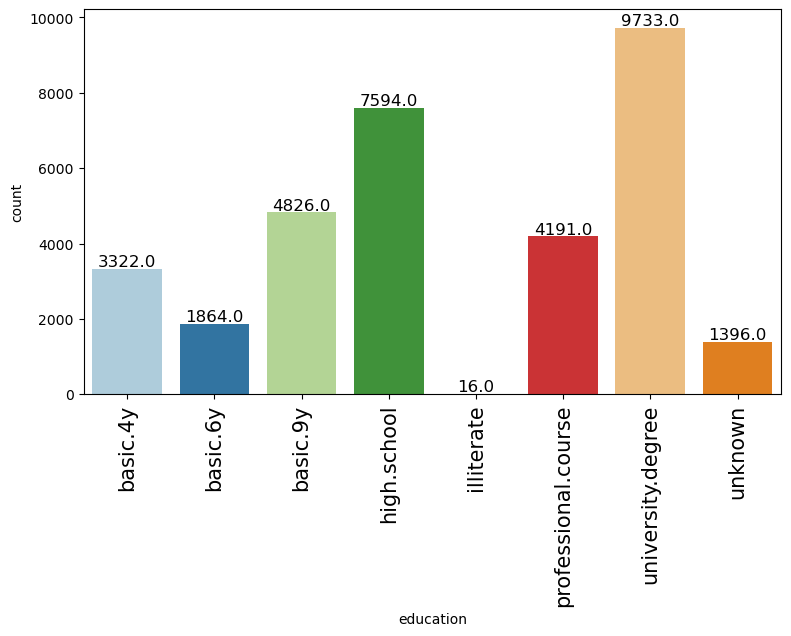

In [17]:
labeled_barplot(Data, "education")

- The bar chart illustrates the education levels of the bank's clients, showing the largest number hold a university degree, indicating a highly educated customer base. High school graduates also make up a significant portion.

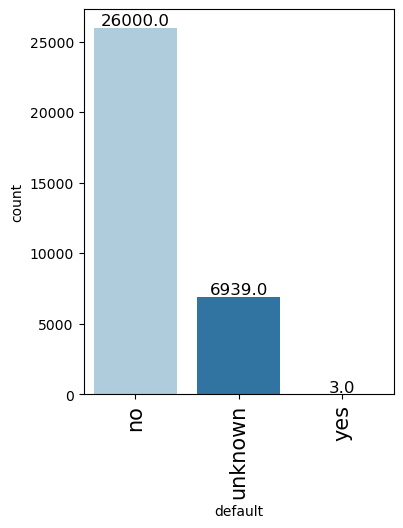

In [18]:
labeled_barplot(Data, "default")

- The bar chart shows that the vast majority of the bank's clients have not defaulted on their credit, which suggests financial reliability among the customer base.

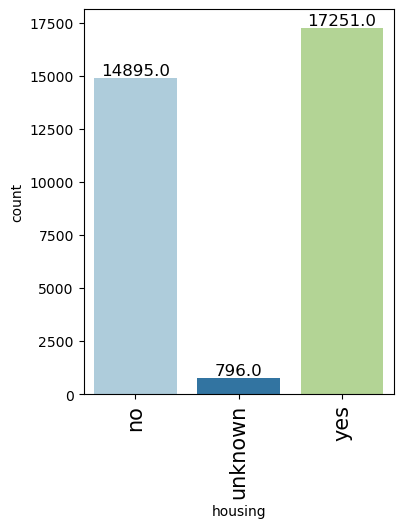

In [19]:
labeled_barplot(Data, "housing")

- The bar chart depicts housing loan status among the bank's clients, showing more clients have housing loans than those who do not. A small proportion of the clients' housing loan status is unknown.

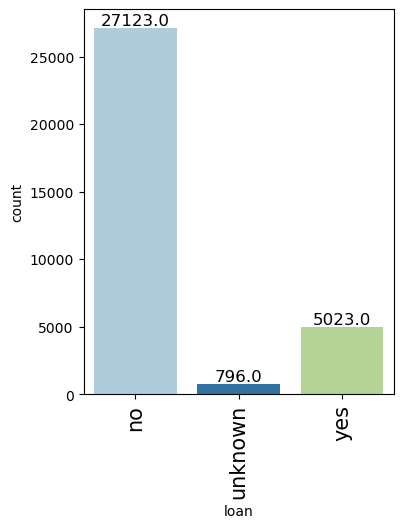

In [20]:
labeled_barplot(Data, "loan")

- The bar chart shows that most of the bank's clients do not have a personal loan, with a smaller number that do. There's also a small category where the loan status is unknown.

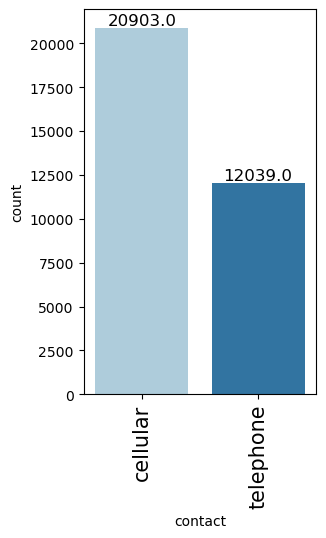

In [21]:
labeled_barplot(Data, "contact")

- The bar chart indicates that the bank contacts most clients via cellular phones rather than landlines. This suggests the bank's communication strategy is modern and mobile-focused, which may be more effective in reaching clients who are on the go.

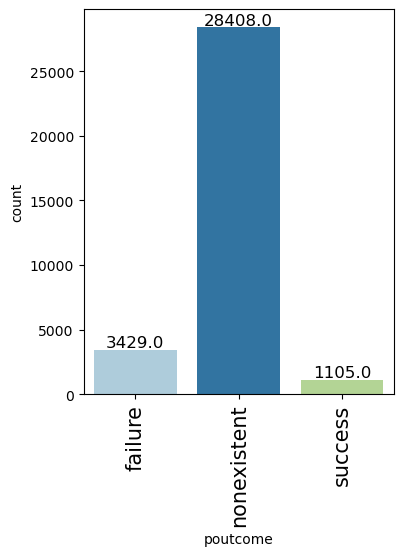

In [22]:
labeled_barplot(Data, "poutcome")

- The bar chart shows the outcomes of the bank's previous marketing campaigns. The 'nonexistent' category is the most populated, indicating that many clients have not been contacted in a previous campaign. There are some cases of 'failure' and relatively few 'successes', suggesting that past campaigns may not have been very effective or that a new strategy may be needed for future campaigns.

no     29230
yes     3712
Name: term_deposit, dtype: int64


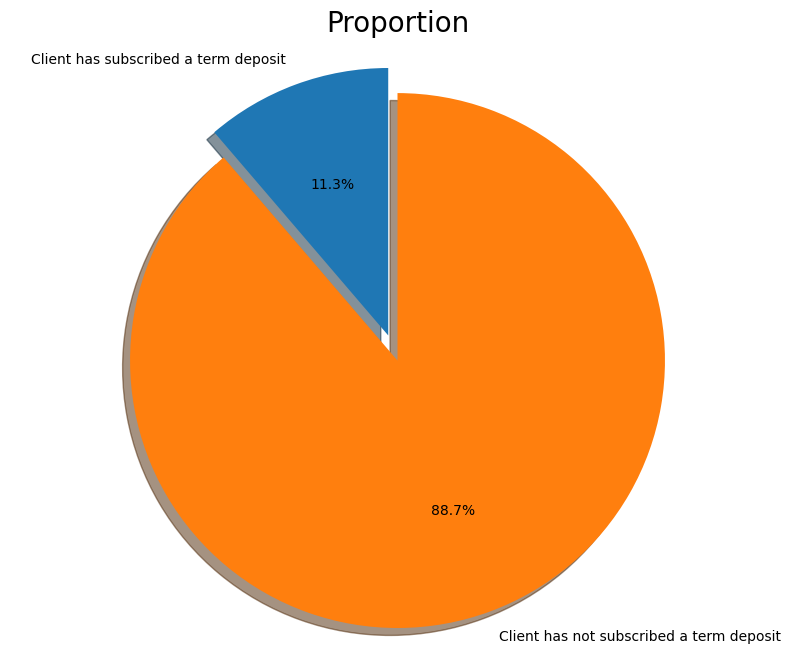

In [23]:
print(Data.term_deposit.value_counts())
labels = 'Client has subscribed a term deposit', 'Client has not subscribed a term deposit'
sizes = [Data.term_deposit[Data['term_deposit']=='yes'].count(),Data.term_deposit[Data['term_deposit']=='no'].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion", size = 20)
plt.show()

#### Observations
- This pie chart shows that the actual distribution of classes is itself imbalanced for the target variable.
- Only ~11% of the customers in this dataset have actually subscribed a term deposit.
- Hence, this dataset and problem statement represent an example of Imbalanced Classification, which has unique challenges in comparison to performing classification over balanced target variables.

## Bivariate Analysis

In [24]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

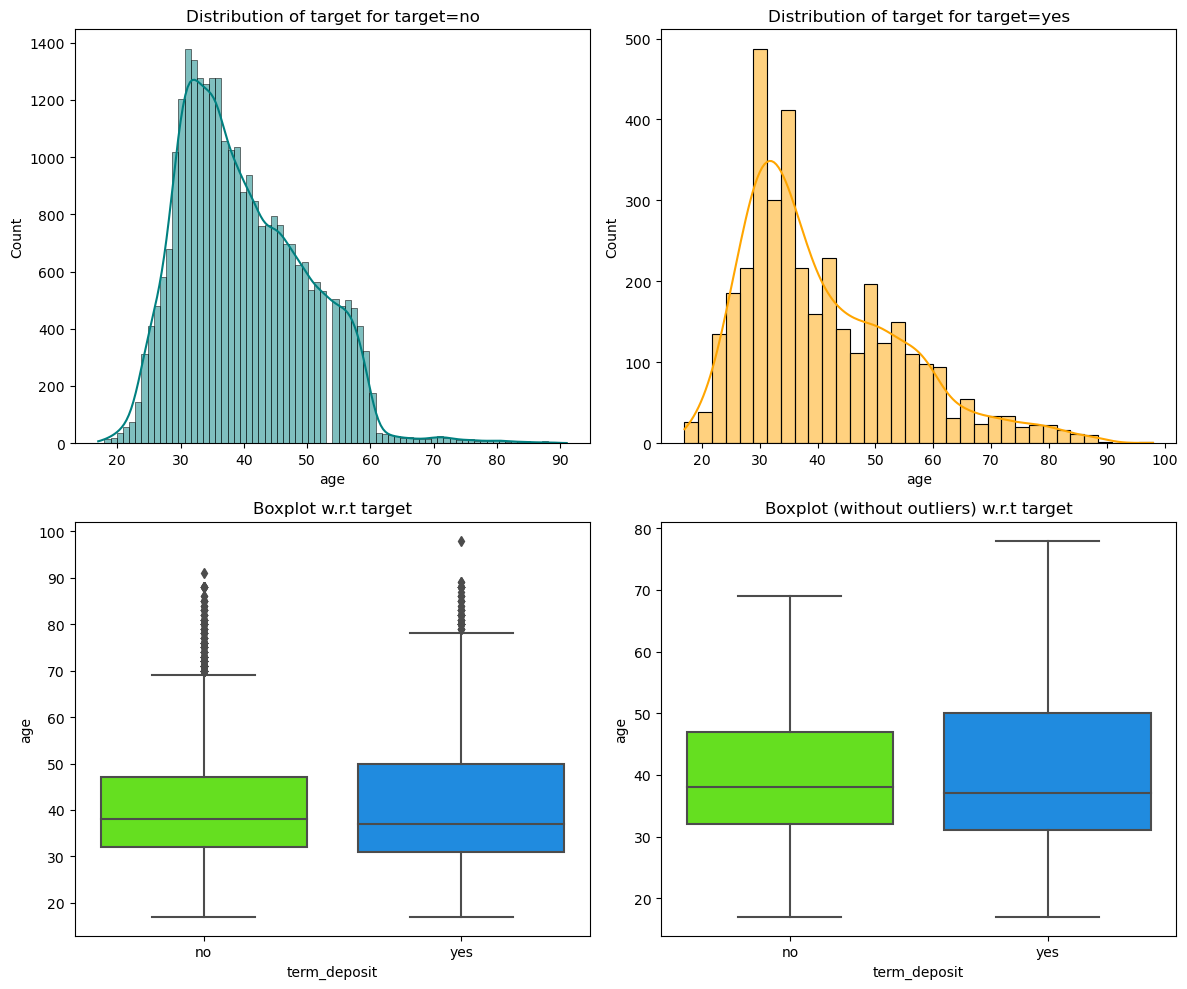

In [25]:
distribution_plot_wrt_target(Data, "age", "term_deposit")

- The histogram for 'no' subscriptions is more spread out, indicating a wider age range of clients not subscribing to term deposits.
- The histogram for 'yes' subscriptions appears more concentrated among younger clients, suggesting that a younger demographic may be more inclined to subscribe.
- The boxplots shows that the median age of clients who subscribed is lower than those who did not, with a tighter age range for subscribers indicated by a smaller interquartile range.

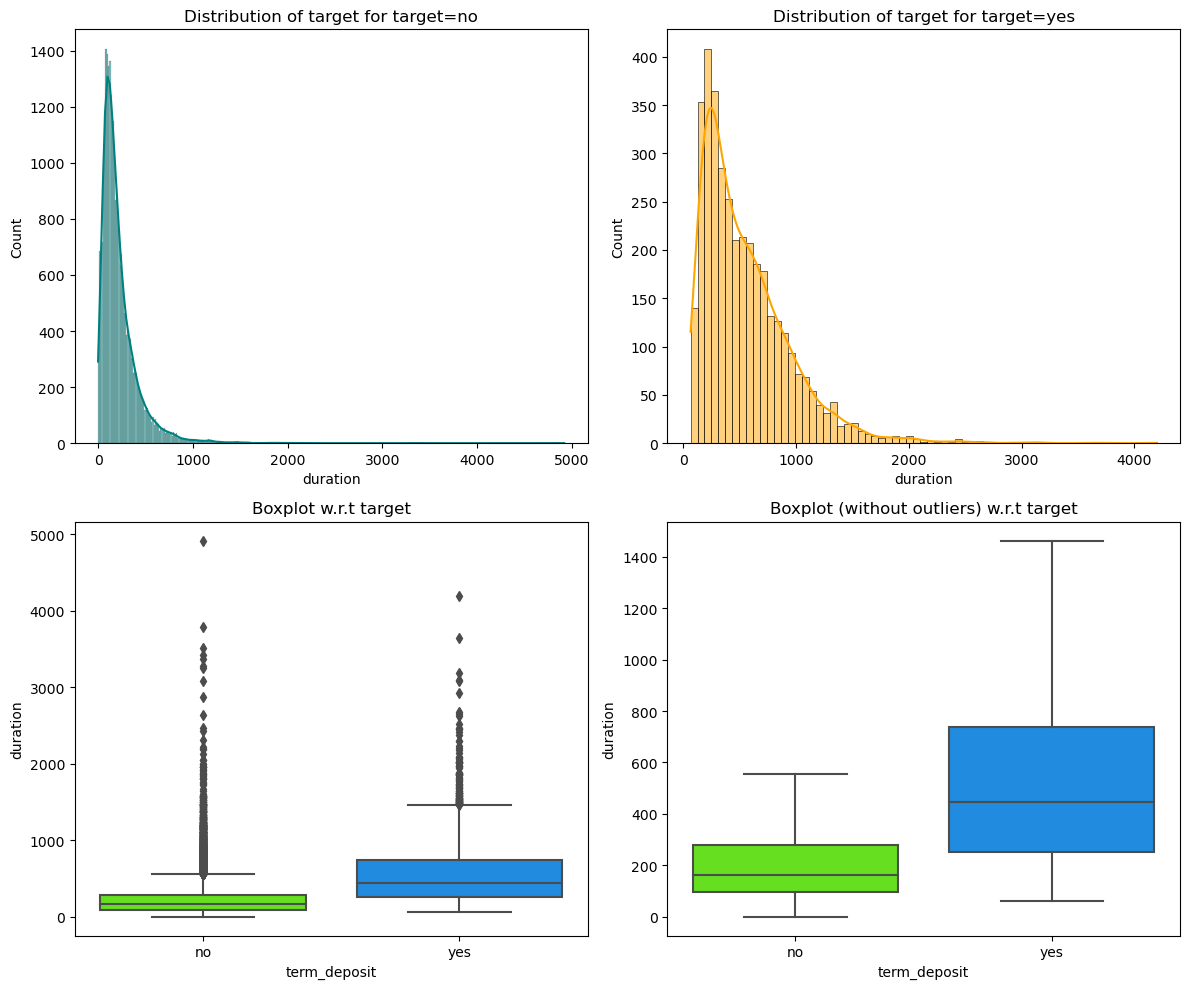

In [26]:
distribution_plot_wrt_target(Data, "duration", "term_deposit")

- The 'no' histogram probably shows that most clients who didn't subscribe had shorter call durations, suggesting that shorter calls correlate with a lower subscription rate.
- The 'yes' histogram might indicate that clients who did subscribe generally had longer call durations, implying that a longer conversation could lead to a higher chance of subscription.
- The boxplots likely reveal a higher median duration for those who subscribed compared to those who didn't, and the presence of outliers may suggest that extremely long calls are not necessarily more effective in securing subscriptions.

In [27]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

term_deposit     no   yes    All
marital                         
All           29230  3712  32942
married       17927  2020  19947
single         7946  1310   9256
divorced       3303   371   3674
unknown          54    11     65
------------------------------------------------------------------------------------------------------------------------


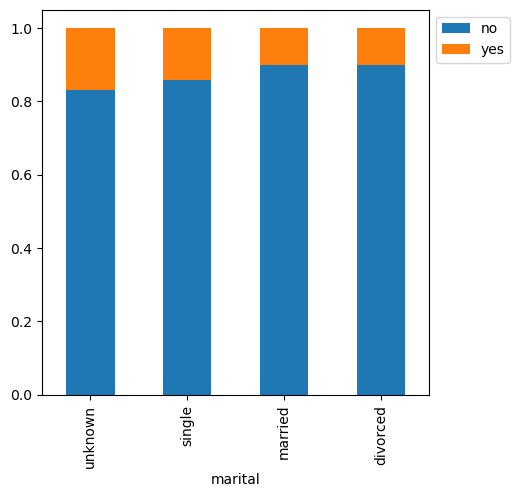

In [28]:
stacked_barplot(Data, "marital", "term_deposit")

- The proportion of clients subscribing to term deposits seems relatively consistent across different marital statuses, with single and divorced clients showing a slightly higher subscription rate compared to married ones.
- The 'married' category has the highest total number of clients, but the subscription rate is not the highest, which might suggest that being married does not necessarily increase the likelihood of subscribing to a term deposit.

term_deposit            no   yes    All
education                              
All                  29230  3712  32942
university.degree     8388  1345   9733
high.school           6779   815   7594
professional.course   3718   473   4191
basic.9y              4457   369   4826
basic.4y              2978   344   3322
unknown               1189   207   1396
basic.6y              1708   156   1864
illiterate              13     3     16
------------------------------------------------------------------------------------------------------------------------


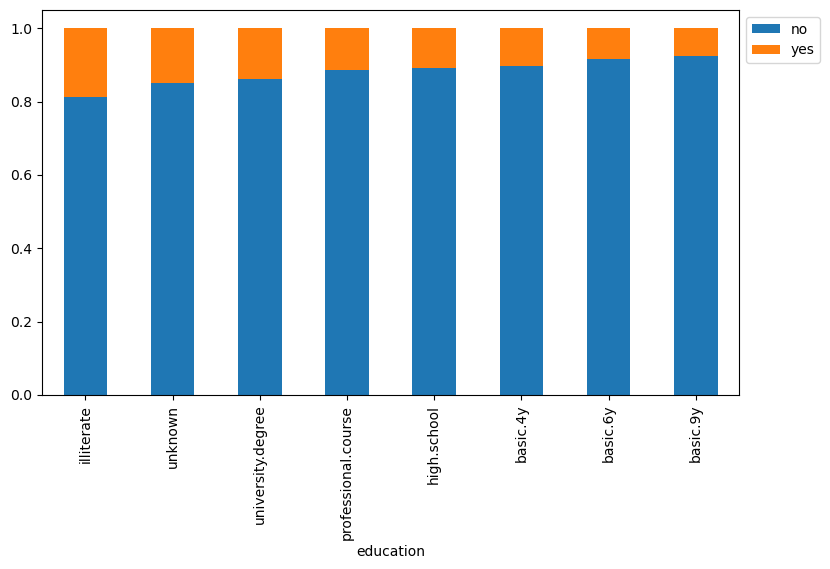

In [29]:
stacked_barplot(Data, "education", "term_deposit")

- Clients with a university degree have the highest number of subscriptions to term deposits, suggesting a correlation between higher education and investment behavior.
- The subscription rate appears somewhat consistent across different education levels, with no dramatic differences in the proportions of 'yes' to 'no'.

term_deposit     no   yes    All
poutcome                        
All           29230  3712  32942
nonexistent   25907  2501  28408
success         388   717   1105
failure        2935   494   3429
------------------------------------------------------------------------------------------------------------------------


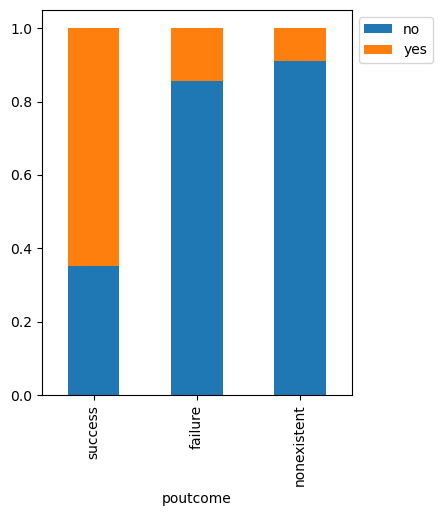

In [30]:
stacked_barplot(Data, "poutcome", "term_deposit")

- Clients with a 'success' in the previous campaign have a much higher rate of subscribing to a term deposit compared to 'failure' or 'nonexistent' outcomes, which suggests previous positive engagement is a strong predictor for current subscription.
- A significant portion of clients who did not subscribe ('no') to a term deposit had a 'nonexistent' outcome from the previous campaign, indicating they may not have been engaged effectively before.
- The 'failure' category has a more balanced distribution between 'yes' and 'no', which might imply that even after a failed campaign, clients are still open to subscribing under different circumstances.

term_deposit      no   yes    All
job                              
All            29230  3712  32942
admin.          7242  1070   8312
technician      4813   585   5398
blue-collar     6925   515   7440
retired         1016   348   1364
management      2076   269   2345
services        2941   254   3195
student          494   217    711
self-employed    980   119   1099
unemployed       682   116    798
entrepreneur    1060   100   1160
housemaid        769    86    855
unknown          232    33    265
------------------------------------------------------------------------------------------------------------------------


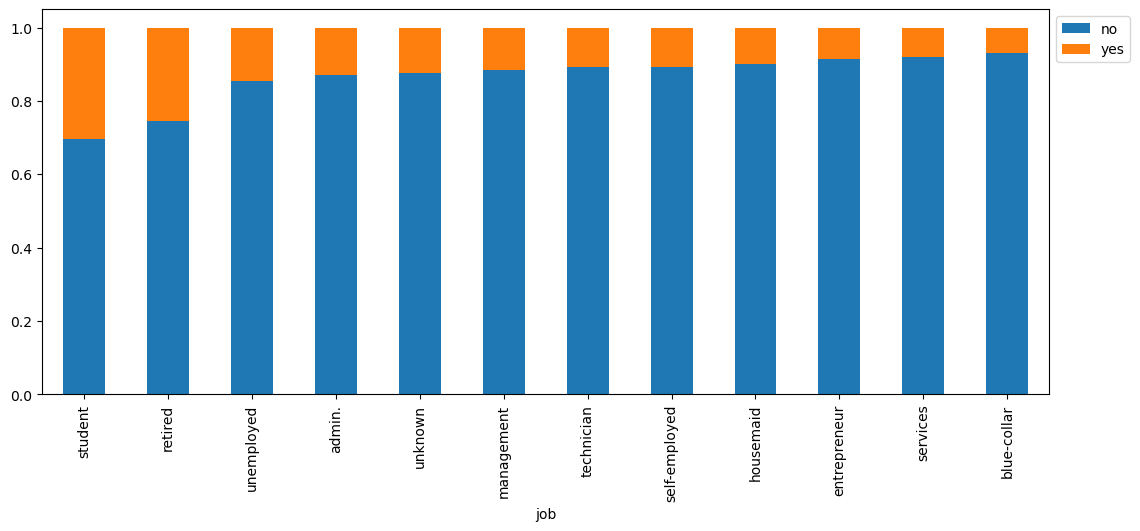

In [31]:
stacked_barplot(Data, "job", "term_deposit")

- The subscription rate varies across different job categories, with some professions like 'student', 'retired', and 'unemployed' possibly showing a higher relative subscription rate to term deposits than others.
- 'Admin.' and 'technician' job categories have a large number of clients who did not subscribe ('no'), but also a substantial count that did ('yes'), suggesting a mixed response to term deposit offerings within these groups.

# Encoding Categorical features 

In [32]:
#create the object for LabelEncoder class
le = LabelEncoder()

#first we label encode our target variable
Data["term_deposit"] = le.fit_transform(Data["term_deposit"])

In [33]:
#intialize the CatBoostEncoder
cb_encoder = CatBoostEncoder()

cat_cols = Data.select_dtypes(include="object").columns.to_list()


# Fit and transform the categorical columns
encoded_df = cb_encoder.fit_transform(Data[cat_cols], Data['term_deposit'])
# Replace original categorical columns with encoded values
Data[cat_cols] = encoded_df

In [34]:
Data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,term_deposit
0,49,0.112683,0.112683,0.112683,0.112683,0.112683,0.112683,0.112683,0.112683,0.112683,227,4,999,0,0.112683,0
1,37,0.112683,0.056341,0.112683,0.112683,0.056341,0.056341,0.112683,0.056341,0.056341,202,2,999,1,0.112683,0
2,78,0.112683,0.037561,0.112683,0.056341,0.037561,0.037561,0.056341,0.112683,0.112683,1148,1,999,0,0.056341,1
3,36,0.112683,0.278171,0.056341,0.370894,0.112683,0.278171,0.056341,0.112683,0.556341,120,2,999,0,0.370894,0
4,59,0.556341,0.112683,0.037561,0.278171,0.278171,0.222537,0.370894,0.112683,0.112683,368,2,999,0,0.278171,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,28,0.079534,0.141542,0.107336,0.128909,0.115601,0.112758,0.147080,0.092381,0.116167,192,1,999,0,0.088052,0
32946,52,0.108394,0.101289,0.112888,0.128904,0.115594,0.112754,0.147073,0.101719,0.109195,64,1,999,1,0.144098,0
32947,54,0.128774,0.101284,0.076484,0.128899,0.109321,0.112328,0.147066,0.092365,0.102498,131,4,999,0,0.088049,0
32948,29,0.128759,0.101279,0.138215,0.128894,0.109313,0.112750,0.053008,0.063504,0.109178,165,1,999,0,0.088046,0


# Splitting the Data

In [35]:
## Separating Independent and Dependent Columns
X = Data.drop(['term_deposit'],axis=1)
Y = Data[['term_deposit']]

In [36]:
Y.head()

,term_deposit
0,0
1,0
2,1
3,0
4,0


In [37]:
# Splitting the dataset into the Training and Testing set.

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify = Y)

In [38]:
###Checking the shape of train and test sets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(26353, 15)
(6589, 15)
(26353, 1)
(6589, 1)


# Model Building

### Building the Artificial Neural Network
- We will build our model using the **Sequential** function imported from tensorflow.keras.models.
- We can add the **Dense** layers with number of neurons of our choice using **.add** method.

In [39]:
# Defining the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
1483/1483 [==============================] - 11s 4ms/step - loss: 0.3818 - accuracy: 0.8841 - val_loss: 0.2568 - val_accuracy: 0.8915
Epoch 2/10
1483/1483 [==============================] - 5s 3ms/step - loss: 0.2569 - accuracy: 0.8951 - val_loss: 0.3582 - val_accuracy: 0.8957
Epoch 3/10
1483/1483 [==============================] - 6s 4ms/step - loss: 0.2558 - accuracy: 0.9004 - val_loss: 0.2435 - val_accuracy: 0.9074
Epoch 4/10
1483/1483 [==============================] - 6s 4ms/step - loss: 0.2552 - accuracy: 0.9006 - val_loss: 0.2474 - val_accuracy: 0.9071
Epoch 5/10
1483/1483 [==============================] - 6s 4ms/step - loss: 0.2536 - accuracy: 0.9009 - val_loss: 0.2430 - val_accuracy: 0.9093
Epoch 6/10
1483/1483 [==============================] - 7s 5ms/step - loss: 0.2529 - accuracy: 0.9017 - val_loss: 0.2452 - val_accuracy: 0.9055
Epoch 7/10
1483/1483 [==============================] - 5s 4ms/step - loss: 0.2523 - accuracy: 0.9016 - val_loss: 0.2416 - val_accuracy

In [40]:
# Creating metric function

def metrics_score(actual, predicted):
    
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Subscribed', 'Subscribed'], yticklabels = ['Not Subscribed', 'Subscribed'])
    plt.ylabel('Actual')
    
    plt.xlabel('Predicted')
    
    plt.show()

824/824 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     23383
           1       0.47      0.63      0.54      2970

    accuracy                           0.88     26353
   macro avg       0.71      0.77      0.73     26353
weighted avg       0.90      0.88      0.89     26353



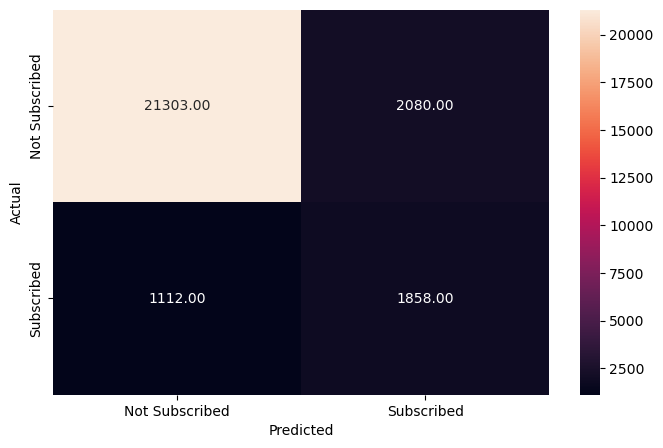

In [41]:
# Checking performance on the training data
y_pred_train_ANN = model.predict(X_train)

y_pred_binary = (y_pred_train_ANN > 0.2).astype("int32")

metrics_score(y_train, y_pred_binary)

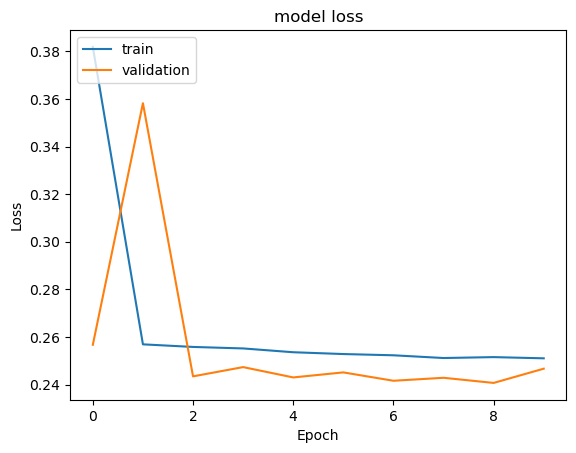

In [42]:
#Plotting Train Loss vs Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

206/206 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      5847
           1       0.46      0.62      0.53       742

    accuracy                           0.88      6589
   macro avg       0.71      0.77      0.73      6589
weighted avg       0.90      0.88      0.88      6589



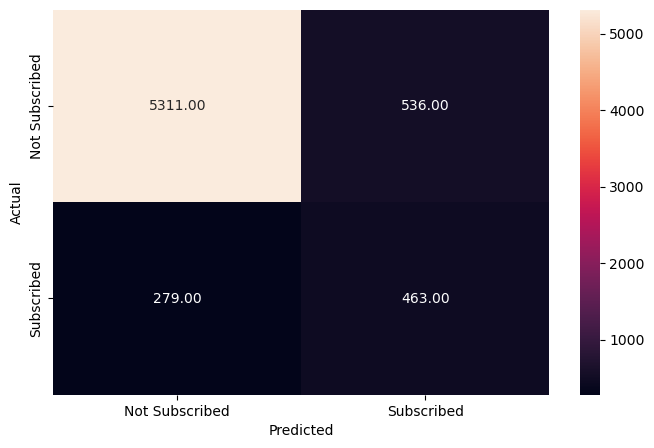

In [43]:
# Checking performance on the test data
y_pred_test_ANN = model.predict(X_test)

y_pred_binary = (y_pred_test_ANN > 0.2).astype("int32")

metrics_score(y_test, y_pred_binary)

### **Building a Decision Tree Model**

* We will build our model using the **DecisionTreeClassifier function.** 
* If the frequency of class A is 89% and the frequency of class B is 11%, then class B will become the dominant class and **the decision tree will become biased toward the dominant class.**
* **class_weight is a hyperparameter** for the decision tree classifier, and in this case, we can pass a dictionary {0:0.89, 1:0.11} to the model to specify the weight of each class and the decision tree will give more weightage to class 1.

In [44]:
# Building decision tree model
dt = DecisionTreeClassifier(class_weight = {0: 0.89, 1: 0.11}, random_state = 1)

In [45]:
# Fitting decision tree model
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.89, 1: 0.11}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23383
           1       1.00      1.00      1.00      2970

    accuracy                           1.00     26353
   macro avg       1.00      1.00      1.00     26353
weighted avg       1.00      1.00      1.00     26353



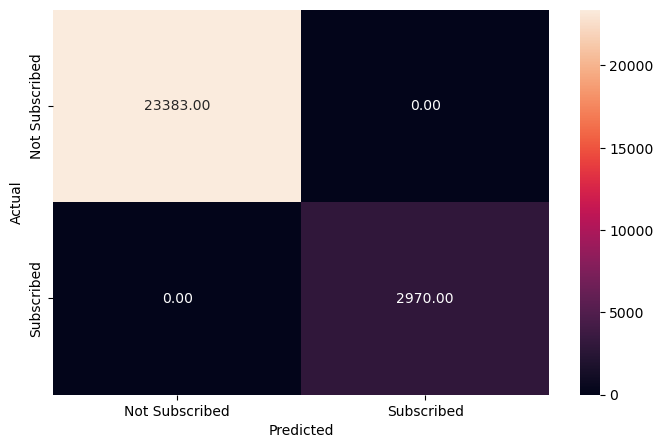

In [46]:
# Checking performance on the training dataset
y_train_pred_dt = dt.predict(X_train)

metrics_score(y_train, y_train_pred_dt)

**Observation:**

- The Decision tree is giving a **100% score for all metrics on the training dataset.**

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5847
           1       0.40      0.47      0.43       742

    accuracy                           0.86      6589
   macro avg       0.67      0.69      0.68      6589
weighted avg       0.87      0.86      0.87      6589



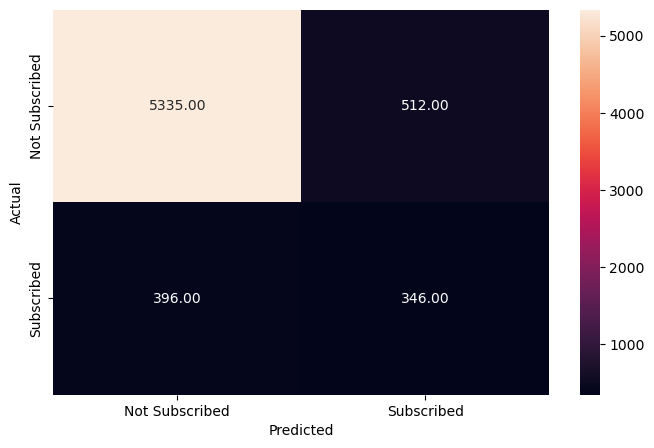

In [47]:
# Checking performance on the test dataset
y_test_pred_dt = dt.predict(X_test)

metrics_score(y_test, y_test_pred_dt)

**Observations:**

- The Decision Tree works well on the training data but **not so well on the test data** as the recall is 0.69 in comparison to 1 for the training dataset, i.e., the Decision Tree is overfitting the training data.

<Axes: xlabel='Importance'>

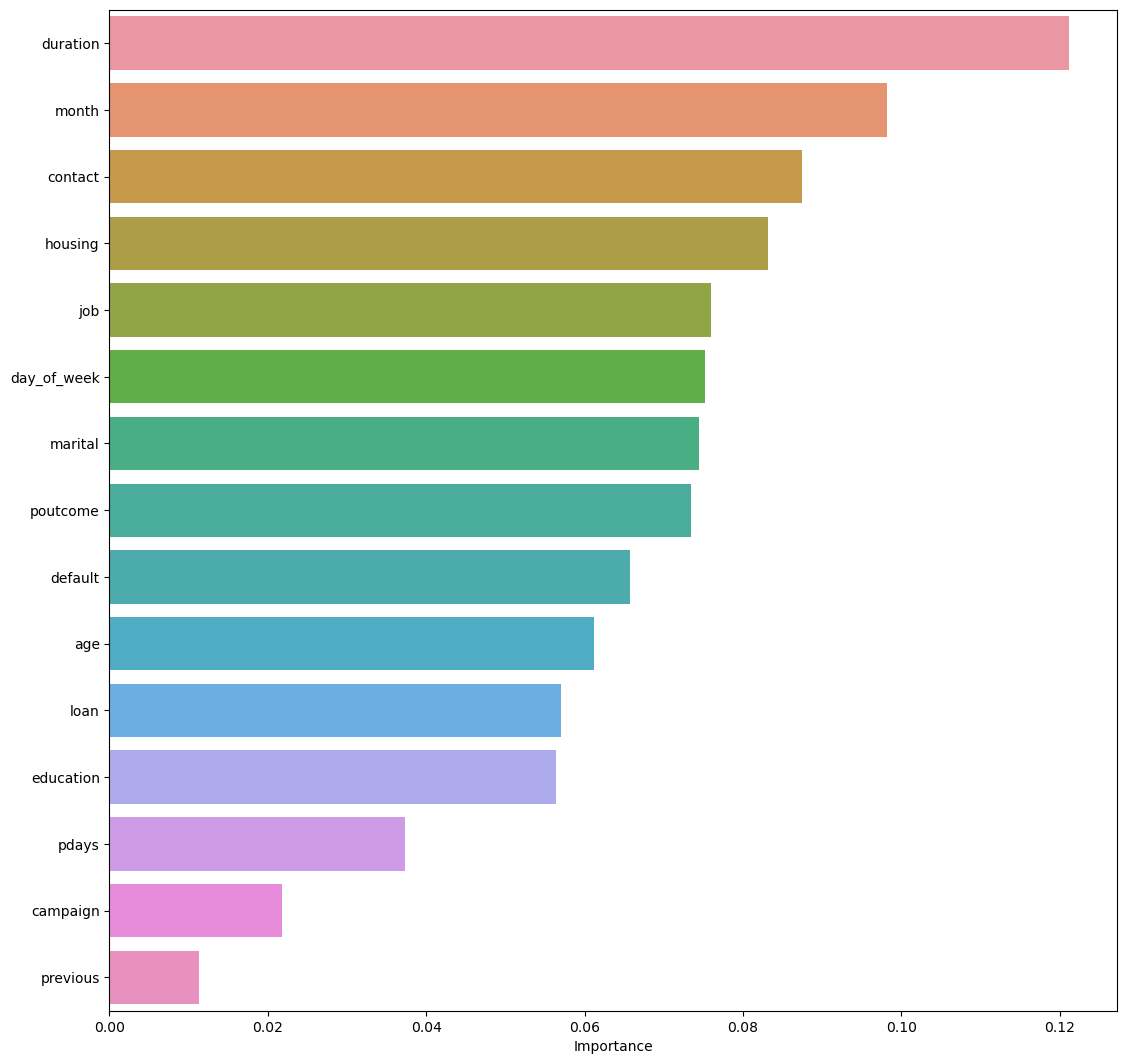

In [48]:
# Plot the feature importance

importances = dt.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x=importance_df.Importance, y=importance_df.index)

**Observations:**

- According to the Decision Tree, **duration is the most important feature, followed by month, contact, and housing.** 
- The other important features are `job`, `day_of_week`, `marital`, and `poutcome`.

**Let's try to tune the model and check if we could improve the results.**

### **Tuning Models**

### **Using GridSearch for Hyperparameter Tuning**

* Hyperparameter tuning is tricky in the sense that **there is no direct way to calculate how a change in the hyperparameter value will reduce the loss of your model**, so we usually resort to experimentation. We'll use Grid search to perform hyperparameter tuning.
* **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

In [49]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(class_weight = {0: 0.89, 1: 0.11}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 10), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

In [50]:
# Fit the best estimator to the data
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.89, 1: 0.11}, criterion='entropy',
                       max_depth=9, min_samples_leaf=5, random_state=1)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     23383
           1       1.00      0.12      0.22      2970

    accuracy                           0.90     26353
   macro avg       0.95      0.56      0.58     26353
weighted avg       0.91      0.90      0.86     26353



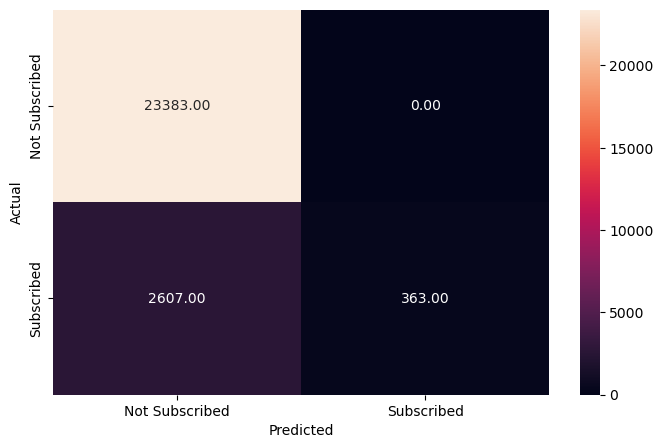

In [51]:
# Checking performance on the training dataset
y_train_pred_dt = dtree_estimator.predict(X_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5847
           1       0.59      0.08      0.14       742

    accuracy                           0.89      6589
   macro avg       0.74      0.54      0.54      6589
weighted avg       0.86      0.89      0.85      6589



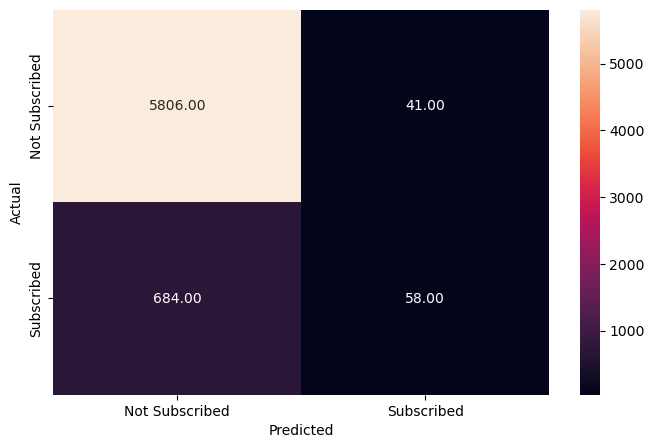

In [52]:
# Checking performance on the test dataset
y_test_pred_dt = dtree_estimator.predict(X_test)

metrics_score(y_test, y_test_pred_dt)

**Observations:**

- This tunned model is still overfitting on the training data and not giving good results on test data.

### **Building the Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample, a decision tree makes a prediction. 

**The results from all the decision trees are combined and the final prediction is made using voting for classification problems.**

In [53]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight = {0: 0.89, 1: 0.11}, random_state = 1)

rf_estimator.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.89, 1: 0.11}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23383
           1       1.00      1.00      1.00      2970

    accuracy                           1.00     26353
   macro avg       1.00      1.00      1.00     26353
weighted avg       1.00      1.00      1.00     26353



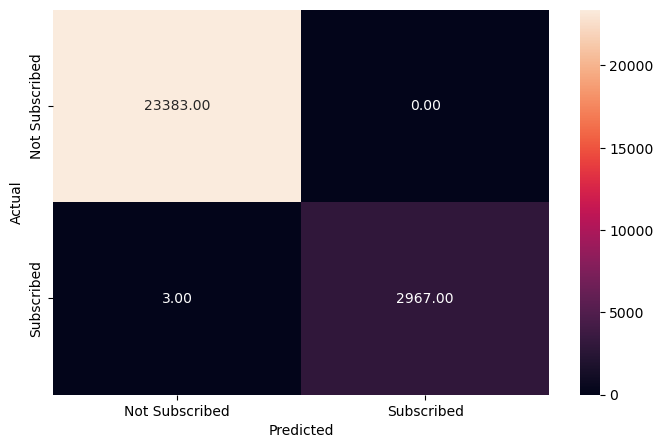

In [54]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(X_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5847
           1       0.59      0.47      0.53       742

    accuracy                           0.90      6589
   macro avg       0.76      0.72      0.74      6589
weighted avg       0.90      0.90      0.90      6589



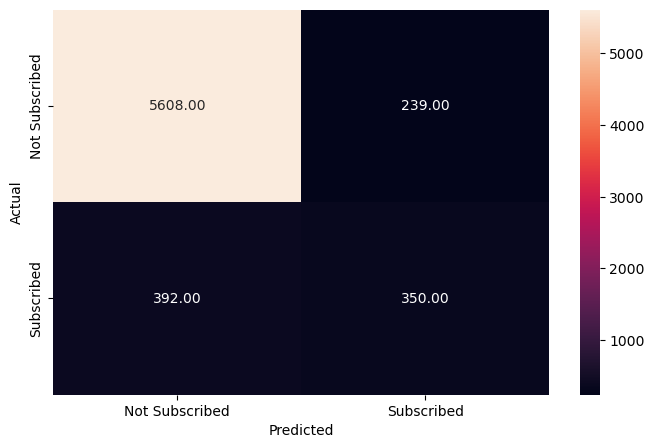

In [55]:
# Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(X_test)

metrics_score(y_test, y_pred_test_rf)

# Models Comparison

In [56]:
def model_performance_classification(model, predictors, target, ANN=None):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    
    predictors: independent variables
    
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)
    
    if ANN == 'y':
        
        pred = (pred > 0.2).astype(int)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall
    
    precision = precision_score(target, pred, average = 'macro')              # To compute precision
               
    acc = accuracy_score(target, pred)                                 # To compute accuracy score
    

    # Creating a dataframe of metrics
    
    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },
        
        index = [0],
    )

    return df_perf

In [57]:
ANN_perf = model_performance_classification(model,X_test,y_test,'y')
DT_perf = model_performance_classification(dt,X_test,y_test)
DT_tunned_perf = model_performance_classification(dtree_estimator,X_test,y_test)
rf_perf = model_performance_classification(rf_estimator,X_test,y_test)

206/206 [==============================] - 1s 4ms/step


In [58]:
models_test_comp_df = pd.concat(
    
    [    
    DT_perf.T, DT_tunned_perf.T,rf_perf.T,ANN_perf.T
    ],
    
    axis = 1,
)

models_test_comp_df.columns = [
    "Decision Tree classifier",
    "Tuned Decision Tree classifier",
    "Random Forest classifier",
    'ANN Model'
]



In [59]:
print("Test performance comparison:")
models_test_comp_df

Test performance comparison:


,Decision Tree classifier,Tuned Decision Tree classifier,Random Forest classifier,ANN Model
Precision,0.667083,0.740233,0.764447,0.706776
Recall,0.689371,0.535577,0.715411,0.766159
Accuracy,0.862195,0.889968,0.904234,0.876309


- It can be observed that the **`Random Forest classifier`** is outperforming other models with an accuracy of **`90%`**.